In [8]:
# importing required libraries
import os
import cv2
import glob
import random
import time
import warnings
import numpy as np
import disarray as da
import seaborn as sns
import tensorflow as tf
from imutils import paths
from itertools import cycle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
#importing sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

/home/sanjeev/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
base_path = "/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/asm_images" # Data Path 
img_list = glob.glob(os.path.join(base_path, '*/*.png'))

In [14]:
cur_dir = os.getcwd()
os.chdir(base_path)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family

for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
fam = []
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
        fam.append(list_fams[label])
    label += 1
num_classes = label

Label: 0	Family:           Gatak	Number of images: 1013
Label: 1	Family:    Kelihos_ver1	Number of images: 398
Label: 2	Family:    Kelihos_ver3	Number of images: 2942
Label: 3	Family:        Lollipop	Number of images: 2478
Label: 4	Family:  Obfuscator.ACY	Number of images: 1228
Label: 5	Family:          Ramnit	Number of images: 1541
Label: 6	Family:           Simda	Number of images: 42
Label: 7	Family:          Tracur	Number of images: 751
Label: 8	Family:           Vundo	Number of images: 475


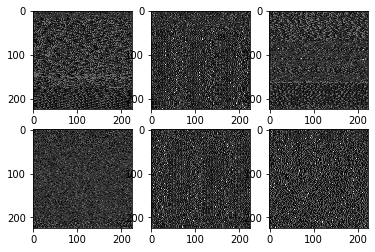

In [15]:
# Sample images from dataset
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [16]:
#loading data
X = np.load("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Plots/X.npy")
X.shape

(10868, 224, 224, 3)

In [17]:
#loading labels
labels = np.load("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Plots/y.npy")
labels.shape

(10868,)

In [18]:
y_cat = to_categorical(labels, num_classes=9)
y_cat.shape

(10868, 9)

In [19]:
IMG_SHAPE = (224, 224, 3)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [20]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [21]:
model = tf.keras.Sequential([base_model,
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(9, activation='softmax')])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 7, 7, 512)         655872    
                                                                 
 dense_1 (Dense)             (None, 7, 7, 256)         131328    
                                                                 
 dense_2 (Dense)             (None, 7, 7, 128)         32896     
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 9)                 1

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [25]:
#data train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.20, random_state=42)

In [26]:
X_train.shape, X_test.shape 

((8694, 224, 224, 3), (2174, 224, 224, 3))

In [27]:
batch_size = 32
epochs = 50

In [28]:
%%time
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(X_test, y_test))

Epoch 1/50
272/272 [==============================] - 240s 310ms/step - loss: 1.7009 - accuracy: 0.3913 - val_loss: 1.3248 - val_accuracy: 0.5699
Epoch 2/50
272/272 [==============================] - 78s 288ms/step - loss: 1.1327 - accuracy: 0.6521 - val_loss: 0.9508 - val_accuracy: 0.7410
Epoch 3/50
272/272 [==============================] - 76s 281ms/step - loss: 0.8829 - accuracy: 0.7680 - val_loss: 0.7883 - val_accuracy: 0.8063
Epoch 4/50
272/272 [==============================] - 75s 273ms/step - loss: 0.7656 - accuracy: 0.8006 - val_loss: 0.7004 - val_accuracy: 0.8215
Epoch 5/50
272/272 [==============================] - 75s 277ms/step - loss: 0.6960 - accuracy: 0.8127 - val_loss: 0.6453 - val_accuracy: 0.8307
Epoch 6/50
272/272 [==============================] - 73s 267ms/step - loss: 0.6482 - accuracy: 0.8230 - val_loss: 0.6042 - val_accuracy: 0.8293
Epoch 7/50
272/272 [==============================] - 72s 263ms/step - loss: 0.6100 - accuracy: 0.8300 - val_loss: 0.5772 - val_a

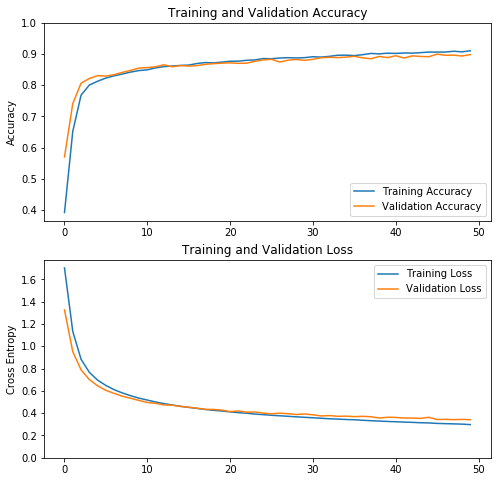

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [30]:
%%time
score = model.evaluate(X_test, y_test, verbose=1)
print("Model evaluated!!")
print('Test loss:', score[0])
print('Test accuracy:', score[1])

68/68 [==============================] - 14s 187ms/step - loss: 0.3413 - accuracy: 0.8983
Model evaluated!!
Test loss: 0.3413187563419342
Test accuracy: 0.8983440399169922
CPU times: user 3min 31s, sys: 4min 29s, total: 8min 1s
Wall time: 16.5 s


In [31]:
%%time
#predictions for test data
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("Prediction done!!")

Prediction done!!
CPU times: user 3min 26s, sys: 5min 13s, total: 8min 40s
Wall time: 17.2 s


In [32]:
preds = np.round(model.predict(X_test), 0)

In [33]:
classification_metrices = metrics.classification_report(y_test, preds, output_dict=True, target_names=list_fams)
df = pd.DataFrame(classification_metrices).transpose()
df.to_csv('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Plots/mobilenetV2_Classification_report.csv')

In [34]:
classification_metrices = metrics.classification_report(y_test, preds, target_names= list_fams)
print(classification_metrices)

                precision    recall  f1-score   support

         Gatak       0.91      0.84      0.88       209
  Kelihos_ver1       1.00      0.83      0.91        76
  Kelihos_ver3       0.95      0.96      0.96       590
      Lollipop       0.93      0.91      0.92       487
Obfuscator.ACY       0.94      0.86      0.90       232
        Ramnit       0.94      0.91      0.93       317
         Simda       0.00      0.00      0.00         7
        Tracur       0.94      0.65      0.77       150
         Vundo       0.80      0.38      0.51       106

     micro avg       0.94      0.86      0.90      2174
     macro avg       0.83      0.71      0.75      2174
  weighted avg       0.93      0.86      0.89      2174
   samples avg       0.86      0.86      0.86      2174



In [6]:
data = [
    {"Class": "Gatak", "Precision": 0.91, "Recall": 0.84, "F1-Score": 0.88, "Support": 209},
    {"Class": "Kelihos_ver1", "Precision": 1.00, "Recall": 0.83, "F1-Score": 0.91, "Support": 76},
    {"Class": "Kelihos_ver3", "Precision": 0.95, "Recall": 0.96, "F1-Score": 0.96, "Support": 590},
    {"Class": "Lollipop", "Precision": 0.93, "Recall": 0.91, "F1-Score": 0.92, "Support": 487},
    {"Class": "Obfuscator.ACY", "Precision": 0.94, "Recall": 0.86, "F1-Score": 0.90, "Support": 232},
    {"Class": "Ramnit", "Precision": 0.94, "Recall": 0.91, "F1-Score": 0.93, "Support": 317},
    {"Class": "Simda", "Precision": 0.00, "Recall": 0.00, "F1-Score": 0.00, "Support": 7},
    {"Class": "Tracur", "Precision": 0.94, "Recall": 0.65, "F1-Score": 0.77, "Support": 150},
    {"Class": "Vundo", "Precision": 0.80, "Recall": 0.38, "F1-Score": 0.51, "Support": 106}
]

precision_values = [row["F1-Score"] for row in data]

for value in precision_values:
    print(value)

0.88
0.91
0.96
0.92
0.9
0.93
0.0
0.77
0.51


Plotting the confusion matrix


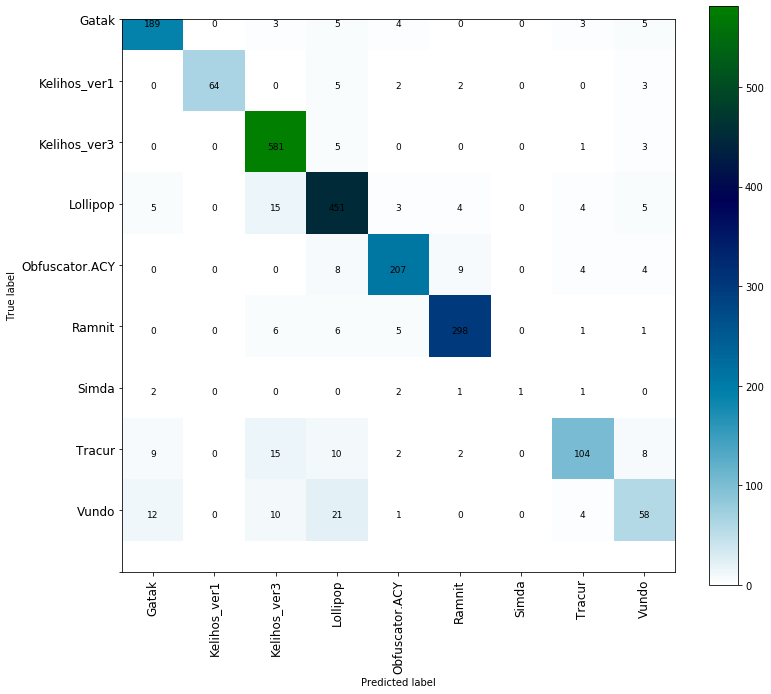

In [35]:
conf_matrix = confusion_matrix(y_true, y_pred)

print("Plotting the confusion matrix")
conf_mat = np.around(conf_matrix, decimals=2)  
figure = plt.gcf()
figure.set_size_inches(11, 10)
plt.imshow(conf_mat, interpolation='nearest', cmap='ocean_r')

for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]), xy=(col,row), ha='center', va='top', fontsize=9)
        
plt.xticks(range(len(list_fams)), list_fams, rotation=90, fontsize=12)
plt.yticks(range(len(list_fams)+1), list_fams, fontsize=12)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.colorbar()

plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Plots/mobilenetV2_cm.eps", bbox_inches='tight')
plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Plots/mobilenetV2_cm.png", bbox_inches='tight')
plt.show()

In [36]:
cm = confusion_matrix(y_true, y_pred)
df = pd.DataFrame(cm)

In [37]:
pd.set_option('display.max_columns', None)  # force to display any number of columns.

In [38]:
#calculating true positives, false positives, true negatives and false negatives from confusion matrix
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [39]:
FP, FN, TP, TN

(array([28,  0, 49, 60, 19, 18,  0, 18, 29]),
 array([20, 12,  9, 36, 25, 19,  6, 46, 48]),
 array([189,  64, 581, 451, 207, 298,   1, 104,  58]),
 array([1937, 2098, 1535, 1627, 1923, 1839, 2167, 2006, 2039]))

In [40]:
#calculating false_omission_rate
NPV = TN/(TN+FN)
FOR = 1-NPV
FOR

array([0.01021972, 0.0056872 , 0.00582902, 0.02164762, 0.01283368,
       0.01022605, 0.00276116, 0.02241715, 0.02299952])

In [41]:
data = df.da.export_metrics(metrics_to_include=['true_positive_rate', 'true_negative_rate', 'false_positive_rate', 
                                              'false_negative_rate', 'false_discovery_rate'])

In [42]:
data.fillna(0.0, inplace=True)

In [43]:
for num, fam in zip(range(25), list_fams):
    data.rename(columns={data.columns[num]:fam}, inplace=True)

data1 = data.drop(columns=['micro-average'])
data1 = data1.T
# data.drop(df.tail(1).index,inplace=True)

data1['false_omission_rate'] = list(FOR)

data1

,true_positive_rate,true_negative_rate,false_positive_rate,false_negative_rate,false_discovery_rate,false_omission_rate
Gatak,0.904306,0.985751,0.014249,0.095694,0.129032,0.010220
Kelihos_ver1,0.842105,1.000000,0.000000,0.157895,0.000000,0.005687
Kelihos_ver3,0.984746,0.969066,0.030934,0.015254,0.077778,0.005829
Lollipop,0.926078,0.964434,0.035566,0.073922,0.117417,0.021648
Obfuscator.ACY,0.892241,0.990216,0.009784,0.107759,0.084071,0.012834
Ramnit,0.940063,0.990307,0.009693,0.059937,0.056962,0.010226
Simda,0.142857,1.000000,0.000000,0.857143,0.000000,0.002761
Tracur,0.693333,0.991107,0.008893,0.306667,0.147541,0.022417
Vundo,0.547170,0.985977,0.014023,0.452830,0.333333,0.023000


In [44]:
for i in data1:
    print('Average of', i, '-->', round((np.average(data1[i])*100), 4))

Average of true_positive_rate --> 76.3656
Average of true_negative_rate --> 98.6317
Average of false_positive_rate --> 1.3683
Average of false_negative_rate --> 23.6344
Average of false_discovery_rate --> 10.5126
Average of false_omission_rate --> 1.2736


In [45]:
#MCC value
print('MCC Score:', round(matthews_corrcoef(y_true, y_pred), 2))

MCC Score: 0.88


In [46]:
preds

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [47]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [50]:
n_classes = 9

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

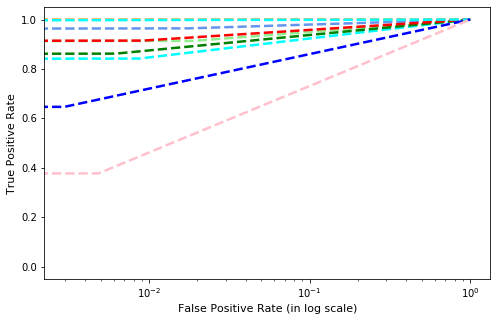

In [51]:
# Compute macro-average ROC curve and ROC area

n_classes = 9
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2.5   # line width
plt.figure(figsize=(8,5))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lightgreen', 'green', 'red', 'cyan', 'blue', 
                 'pink', 'purple', 'brown', 'coral', 'chocolate', 'indigo', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linestyle='dashed', lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.xscale("log")
plt.xlabel('False Positive Rate (in log scale)', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Plots/mobilenetV2_roc.eps", bbox_inches='tight')
plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Plots/mobilenetV2_roc.png", bbox_inches='tight')

plt.show()